In [80]:
# Political Pole Detector
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
import nltk
from sklearn import naive_bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from math import sqrt
import joblib
import string
import re
import sys
import datetime
import html
import os
import timeit
nltk.download('punkt')
nltk.download('wordnet')

# sklearn=0.23.1, pandas=1.0.1
print(sklearn.__version__)
print(pd.__version__)

0.23.1
1.0.1


[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [81]:
# This helps turn .txt files into Excel files .xlsx or CSV files (if you're lucky)
# If files aren't cooperative...run this code then copy and paste the dates into column one
# and articles into column two in Excel, then save as an Excel file.

#with open('articles/NewsMax.txt', 'r', encoding='utf-8') as f:
#        for line in f:
#            date = line
#            date = date[0:12]
#            with open('csvs/NewsMax.txt', 'a+', encoding='utf-8') as s:
#                s.write(date + "\n")

#with open('articles/NewsMax.txt', 'r', encoding='utf-8') as f:
#        for line in f:
#            article = line
#            article = article[12:]
#            with open('csvs/NewsMax2.txt', 'a+', encoding='utf-8') as s:
#                s.write(article)

In [82]:
# Let's see what features we have.

# Character length requirement for articles
length_req = 800

left1 = pd.read_excel("csvs/Huffington.xlsx", 
                  names=["date", "article"])
#left = pd.read_csv('Huffington.csv')
print("We have {:,} left-wing records".format(left1.shape[0]))

for x in range(left1.shape[0]):
    if len(left1['article'][x]) < length_req:
        left1.drop(x, inplace=True)

print("We have {:,} left-wing records > {} characters long".format(left1.shape[0], length_req))

# Only keep the unique article rows and their values
left1.drop_duplicates("article", keep='first', inplace=True)

print("{:,} Records are unique".format(
    left1.shape[0]))

left1['date'] = left1['date'].str.replace(',', '')

left1.head()

We have 4,355 left-wing records
We have 4,314 left-wing records > 800 characters long
4,304 Records are unique


,date,article
0,2020-01-01,"Elizabeth Warren Rips ‘Fawning, Spineless’ Rep..."
1,2020-01-01,These Major New Laws Take Effect Today From ma...
2,2020-01-01,U.S. To Deploy Hundreds Of Troops To Iraq Afte...
3,2020-01-01,Police And Protesters Clash In New Year’s Rall...
4,2020-01-01,Trump Shrugs Off Kim Jong Un’s Nuclear Testing...


In [83]:
left2 = pd.read_excel("csvs/Salon.xlsx", 
                  names=["date", "article"])
#left = pd.read_csv('Huffington.csv')
print("We have {:,} left-wing records".format(left2.shape[0]))

left2['date'].fillna("", inplace=True)
left2['article'].fillna("", inplace=True)

for x in range(left2.shape[0]):
    if len(left2['article'][x]) < length_req:
        left2.drop(x, inplace=True)

print("We have {:,} left-wing records > {} characters long".format(left2.shape[0], length_req))

# Only keep the unique article rows and their values
left2.drop_duplicates("article", keep='first', inplace=True)

print("{:,} Records are unique".format(
    left2.shape[0]))

left2['date'] = left2['date'].str.replace(',', '')

left2.head()

We have 2,303 left-wing records
We have 2,278 left-wing records > 800 characters long
1,987 Records are unique


,date,article
0,2020-01-15,"Lev Parnas, the indicted associate of former N..."
1,2020-01-26,President Donald Trump's comments about Thomas...
2,2020-05-31,This article originally appeared at Common Dre...
3,2020-05-31,Trump admin rush migrant children deportations...
4,2020-05-31,"The late Gore Vidal once confessed, with chara..."


In [84]:
left_min = [left1.shape[0], left2.shape[0]]
left_min_entries = min(left_min)

left1 = left1.sample(left_min_entries)
left2 = left2.sample(left_min_entries)

print("Huffpost: {} entries".format(left1.shape[0]))
print("Salon: {} entries".format(left2.shape[0]))

Huffpost: 1987 entries
Salon: 1987 entries


In [85]:
left = pd.concat([left1, left2])
print("We have {:,} left-wing records".format(left.shape[0]))

We have 3,974 left-wing records


In [86]:
# Let's see what features we have.
right1 = pd.read_excel("csvs/NewsMax.xlsx",
                     names=["date", "article"])
print("We have {:,} right-wing records".format(right1.shape[0]))

#count = right.shape[0]

for x in range(right1.shape[0]):
    if len(right1['article'][x]) < length_req:
        right1.drop(x, inplace=True)

print("We have {:,} right-wing records > {} characters long".format(right1.shape[0], length_req))

# Only keep the unique rows and their values
right1.drop_duplicates("article", keep='first', inplace=True)

print("{:,} Records are unique".format(
    right1.shape[0]))

right1['date'] = right1['date'].str.replace(',', '')

right1.head()

We have 5,829 right-wing records
We have 5,637 right-wing records > 800 characters long
5,588 Records are unique


,date,article
0,2020-01-01,Klobuchar Hits Trump's Golf: 'I Spent 0 Days' ...
1,2020-01-01,WashPost: Bloomberg's China Ties Are Conflict ...
2,2020-01-01,James Woolsey to Newsmax TV: Target the IRGC N...
3,2020-01-01,Report: US Service Members Killed in Afghanist...
4,2020-01-01,Bernie Kerik to Newsmax TV: Trump Sends World ...


In [87]:
right2 = pd.read_excel("csvs/Redstate.xlsx",
                     names=["date", "article"])
print("We have {:,} right-wing records".format(right2.shape[0]))

#count = right.shape[0]

for x in range(right2.shape[0]):
    if len(right2['article'][x]) < length_req:
        right2.drop(x, inplace=True)

print("We have {:,} right-wing records > {} characters long".format(right2.shape[0], length_req))

# Only keep the unique rows and their values
right2.drop_duplicates("article", keep='first', inplace=True)

print("{:,} Records are unique".format(
    right2.shape[0]))

right2['date'] = right2['date'].str.replace(',', '')

right2.head()

We have 2,270 right-wing records
We have 2,207 right-wing records > 800 characters long
2,111 Records are unique


,date,article
0,2020-01-15,Even CNN Calls Out Democrats For How They Cele...
1,2020-01-26,The Isolation of Connectivity Image by Thom...
2,2020-05-29,Mayor of Minneapolis Lets Rioters Burn Down Po...
3,2020-05-29,Watch: CNN Crew Arrested by MN State Police Li...
4,2020-05-31,Buffalo Mayor Has Best Response to Rioter Who ...


In [88]:
right_min = [right1.shape[0], right2.shape[0]]
right_min_entries = min(right_min)

right1 = right1.sample(right_min_entries)
right2 = right2.sample(right_min_entries)

print("NewsMax: {} entries".format(right1.shape[0]))
print("Redstate: {} entries".format(right2.shape[0]))

NewsMax: 2111 entries
Redstate: 2111 entries


In [89]:
right = pd.concat([right1, right2])
print("We have {:,} right-wing records".format(right.shape[0]))

We have 4,222 right-wing records


In [90]:
# Check for null values
right.isnull().sum(axis=0)

date       7
article    0
dtype: int64

In [91]:
left.isnull().sum(axis=0)

date       0
article    0
dtype: int64

In [92]:
# If there were null values, the below will replace them.
left['date'].fillna("", inplace=True)
right['date'].fillna("", inplace=True)
#right['article'].fillna("", inplace=True)
#right.isnull().sum(axis=0)

In [93]:
# Search for non-null valued rows
# Useful for fixing when data went into three or more columns instead of two in the Excel sheet.
#left[left['date'].notnull()]
#right[right['date'].notnull()]

# Finds all null valued rows
left[~left['date'].notnull()]
#right[~right['date'].notnull()]

,date,article


In [94]:
left['pole'] = 0  # Make a column 'pole', assign a value of 0 to indicate left articles
print("We have {:,} left-wing records".format(left.shape[0]))
right['pole'] = 1
print("We have {:,} right-wing records".format(right.shape[0]))

if (right.shape[0] > left.shape[0]):
    print("Getting random sample of right-wing records")
    right = right.sample(left.shape[0]) # randomly generate samples from right equal to left's length. (Can be set to random_state=0)
else:
    print("Getting random sample of left-wing records")
    left = left.sample(right.shape[0]) # randomly generate samples from right equal to left's length. (Can be set to random_state=0)

all_data = pd.concat([left, right]) # combine left and right datasets
column_names = all_data.columns.values
all_data.columns = column_names
all_data = all_data.sample(frac=1).reset_index(drop=True) # randomly shuffle your rows
all_data['date'] = all_data['date'].str.replace(',', '')
all_data.head()

We have 3,974 left-wing records
We have 4,222 right-wing records
Getting random sample of right-wing records


,date,article,pole
0,2020-07-26,This article originally appeared at Common Dre...,0
1,2020-01-27,Democrats Repeat Demands For Impeachment Trial...,0
2,2020-02-22,1-Delegate Nevada Precinct Gets No Votes in Ca...,1
3,2020-05-22,FBI Director Orders Internal Review Of Flynn I...,0
4,2020-01-28,"Trump, Netanyahu Unveil Long-Awaited Middle Ea...",0


In [95]:
print("{:,} / {:,} Current Records".format(
    all_data['pole'].sum(),
    all_data.shape[0]))

# Only keep the unique rows and their values
all_data.drop_duplicates("article", keep=False, inplace=True)
print("{:,} Records are unique".format(
    all_data.shape[0]))

print("{:,} / {:,} Current Records".format(
    all_data['pole'].sum(),
    all_data.shape[0]))

3,974 / 7,948 Current Records
7,948 Records are unique
3,974 / 7,948 Current Records


In [96]:
# Save the rows used from notspam to a CSV.
# Can give you a good idea of what constitutes a good set of data
# when a run results in high accuracy.
#notspam.to_csv(r'positive.csv')
#spam.to_csv(r'negative.csv')

# We can see there's some strange html characters present.
# Very important to cast the entire column as a string type first, so some of these numeric values come in as strings.
# Otherwise, the row values for these comments where they're present will turn into NaN values.
#all_data['article'] = all_data['article'].astype(str).str.replace(r'&#39;', "\'").astype('string')

# This is a more clean and thorough url decoding function for decoding any character string...
all_data['article'] = all_data['article'].astype(str).apply(lambda x: html.unescape(x))

In [97]:
# Store the original comments in a new column
all_data['unfiltered_articles'] = all_data['article'].values
all_data.head()

,date,article,pole,unfiltered_articles
0,2020-07-26,This article originally appeared at Common Dre...,0,This article originally appeared at Common Dre...
1,2020-01-27,Democrats Repeat Demands For Impeachment Trial...,0,Democrats Repeat Demands For Impeachment Trial...
2,2020-02-22,1-Delegate Nevada Precinct Gets No Votes in Ca...,1,1-Delegate Nevada Precinct Gets No Votes in Ca...
3,2020-05-22,FBI Director Orders Internal Review Of Flynn I...,0,FBI Director Orders Internal Review Of Flynn I...
4,2020-01-28,"Trump, Netanyahu Unveil Long-Awaited Middle Ea...",0,"Trump, Netanyahu Unveil Long-Awaited Middle Ea..."


In [98]:
# Proper Noun Removal
# Do this before lowercasing all text
from nltk.tag import pos_tag

def proper_noun_removal(text):
    tagged_sent = pos_tag(text.split())
    return [w for w, pos in tagged_sent if pos != 'NNP']
    
all_data['article'] = all_data['article'].apply(proper_noun_removal)

# Turn the list of tokens back into a sentence
all_data['article'] = [' '.join(comment) for comment in all_data['article']]
all_data.head()

,date,article,pole,unfiltered_articles
0,2020-07-26,This article originally appeared at It is lice...,0,This article originally appeared at Common Dre...
1,2020-01-27,Democrats For After new report says a draft ou...,0,Democrats Repeat Demands For Impeachment Trial...
2,2020-02-22,1-Delegate Gets No Votes in Democrats have dis...,1,1-Delegate Nevada Precinct Gets No Votes in Ca...
3,2020-05-22,Of The moved earlier this month to dismiss the...,0,FBI Director Orders Internal Review Of Flynn I...
4,2020-01-28,The Palestinians have already rejected the pro...,0,"Trump, Netanyahu Unveil Long-Awaited Middle Ea..."


In [99]:
# Checks to make sure proper nouns were removed
#all_data['article'][0]
#all_data['unfiltered_articles'][0]

In [100]:
# Clean the text
# The apostrophes here are very specific.
# The regular ' will not work from keyboard.
# You have to use print(all_data.head()) and copy and paste that apostrophe into the str.replace()
all_data['article'] = all_data['article'].str.lower()
all_data['article'] = all_data['article'].str.replace(r"u.s.", "united states")
all_data['article'] = all_data['article'].str.replace(r"what’s", "what is")
all_data['article'] = all_data['article'].str.replace(r"’s", " ")
all_data['article'] = all_data['article'].str.replace(r"’ve", "have")
all_data['article'] = all_data['article'].str.replace(r"’re", "are")
all_data['article'] = all_data['article'].str.replace(r"’ll", "will")
all_data['article'] = all_data['article'].str.replace(r"can’t", "can not")
all_data['article'] = all_data['article'].str.replace(r"aren’t", "are not")
all_data['article'] = all_data['article'].str.replace(r"couldn’t", "could not")
all_data['article'] = all_data['article'].str.replace(r"didn’t", "did not")
all_data['article'] = all_data['article'].str.replace(r"doesn’t", "does not")
all_data['article'] = all_data['article'].str.replace(r"don’t", "do not")
all_data['article'] = all_data['article'].str.replace(r"hadn’t", "had not")
all_data['article'] = all_data['article'].str.replace(r"hasn’t", "has not")
all_data['article'] = all_data['article'].str.replace(r"haven’t", "have not")
all_data['article'] = all_data['article'].str.replace(r"isn’t", "is not")
all_data['article'] = all_data['article'].str.replace(r"shouldn’t", "should not")
all_data['article'] = all_data['article'].str.replace(r"wasn’t", "was not")
all_data['article'] = all_data['article'].str.replace(r"weren’t", "were not")
all_data['article'] = all_data['article'].str.replace(r"won’t", "will not")
all_data['article'] = all_data['article'].str.replace(r"wouldn’t", "would not")
all_data['article'] = all_data['article'].str.replace(r"mustn’t", "must not")
all_data['article'] = all_data['article'].str.replace(r"i’m", "i am")

# As are these apostrophes...
all_data['article'] = all_data['article'].str.replace(r"what's", "what is")
all_data['article'] = all_data['article'].str.replace(r"'s", " ")
all_data['article'] = all_data['article'].str.replace(r"'ve", "have")
all_data['article'] = all_data['article'].str.replace(r"'re", "are")
all_data['article'] = all_data['article'].str.replace(r"'ll", "will")
all_data['article'] = all_data['article'].str.replace(r"can't", "can not")
all_data['article'] = all_data['article'].str.replace(r"aren't", "are not")
all_data['article'] = all_data['article'].str.replace(r"couldn't", "could not")
all_data['article'] = all_data['article'].str.replace(r"didn't", "did not")
all_data['article'] = all_data['article'].str.replace(r"doesn't", "does not")
all_data['article'] = all_data['article'].str.replace(r"don't", "do not")
all_data['article'] = all_data['article'].str.replace(r"hadn't", "had not")
all_data['article'] = all_data['article'].str.replace(r"hasn't", "has not")
all_data['article'] = all_data['article'].str.replace(r"haven't", "have not")
all_data['article'] = all_data['article'].str.replace(r"isn't", "is not")
all_data['article'] = all_data['article'].str.replace(r"shouldn't", "should not")
all_data['article'] = all_data['article'].str.replace(r"wasn't", "was not")
all_data['article'] = all_data['article'].str.replace(r"weren't", "were not")
all_data['article'] = all_data['article'].str.replace(r"won't", "will not")
all_data['article'] = all_data['article'].str.replace(r"wouldn't", "would not")
all_data['article'] = all_data['article'].str.replace(r"mustn't", "must not")
all_data['article'] = all_data['article'].str.replace(r"i'm", "i am")
all_data.head()

,date,article,pole,unfiltered_articles
0,2020-07-26,this article originally appeared at it is lice...,0,This article originally appeared at Common Dre...
1,2020-01-27,democrats for after new report says a draft ou...,0,Democrats Repeat Demands For Impeachment Trial...
2,2020-02-22,1-delegate gets no votes in democrats have dis...,1,1-Delegate Nevada Precinct Gets No Votes in Ca...
3,2020-05-22,of the moved earlier this month to dismiss the...,0,FBI Director Orders Internal Review Of Flynn I...
4,2020-01-28,the palestinians have already rejected the pro...,0,"Trump, Netanyahu Unveil Long-Awaited Middle Ea..."


In [101]:
# Custom word removal - these appear too frequently and do not help with generalization.
custom = {'donald j trump', 'donald john trump', 'donald j. trump', 'newsmax', 'redstate', 
          "huffpost", 'salon',
          "___", "donald trump", "trump", "pelosi"}

# Did not work
#for word in custom:
#    all_data["article"]= all_data["article"].replace(word, " ") 

# Did not work
#all_data['article'] = all_data['article'].apply(lambda x: ' '.join([word for word in x.split() if word not in (custom)]))

# Did work
#def customWord(text):
#    custom = {'donald j trump', 'donald john trump', 'donald j. trump', "huffpost", "newsmax"}
#    return text.replace("huffpost", " ") 

for word in custom:
    all_data['article'] = all_data['article'].apply(lambda x: x.replace(word, " "))
    
# Check to see the words were replaced
all_data[all_data['article'].str.contains("newsmax")]

,date,article,pole,unfiltered_articles


In [102]:
# Remove years and digits from being used as features
def remove_years(text):
    text = re.sub(r"[0-9]{4}", " ", text)
    text = re.sub(r"[0-9]{3}", " ", text)
    text = re.sub(r"[0-9]{2}", " ", text)
    text = re.sub(r"[0-9]{1}", " ", text)
    text = re.sub(r"[0-9]{4}ish", " ", text)
    text = re.sub(r"[0-9]{3}ish", " ", text)
    text = re.sub(r"[0-9]{2}ish", " ", text)
    text = re.sub(r"[0-9]{1}ish", " ", text)
    text = re.sub(r"2020-[0-9]{2}-[0-9]{2}", " ", text)
    return text

all_data['article'] = all_data['article'].apply(lambda x: remove_years(x))
all_data.head()

# Punctuation removal - CountVectorizer() does this for you
#punctuation = {'.', ':', ';', "\'", '\"', '!', '?', "\’", '(', ')', '-'}

,date,article,pole,unfiltered_articles
0,2020-07-26,this article originally appeared at it is lice...,0,This article originally appeared at Common Dre...
1,2020-01-27,democrats for after new report says a draft ou...,0,Democrats Repeat Demands For Impeachment Trial...
2,2020-02-22,-delegate gets no votes in democrats have dis...,1,1-Delegate Nevada Precinct Gets No Votes in Ca...
3,2020-05-22,of the moved earlier this month to dismiss the...,0,FBI Director Orders Internal Review Of Flynn I...
4,2020-01-28,the palestinians have already rejected the pro...,0,"Trump, Netanyahu Unveil Long-Awaited Middle Ea..."


In [103]:
all_data[all_data['article'].str.contains("19")]

,date,article,pole,unfiltered_articles


### One-gram - Stopword removal and no lemmatization

In [104]:
#### Training the model

# Using Bigrams as well as single words with n_gram(1, 2) in CountVectorizer()

# Store the best-performing model
# But be sure its recall is good enough for spam.
final_model = []

# Classifiers
# Excluded: GaussianNB, GaussianProcess, MLP, QDA
# Excluding: DecisionTreeClassifier(max_depth=5, random_state=1). 
# Excluding RBF SVM: takes 4+ hours to finish. SVC(gamma=2, C=1, probability=True)
# Excluding: KNeighborsClassifier() (.67 acc), NuSVC, SVC, Decision tree(max_depth=5, random_state=0) (.70 acc) 
#
# Best Results seen: RandomForest : 
# Sometimes SGD exceeds RF here against a small test validation, but against the entire dataset, RF always has higher accuracy.
# Assign random_state=0 or some value just for testing purposes. Applies to SVC, RF, SGD
names = ["Ada Boost", "Logistic Regression", "LinearSVC",
            "Random Forest", "Bernoulli Naive Bayes", "Multinomial Naive Bayes", "SGD"]

classifiers = [AdaBoostClassifier(random_state=0),
                LogisticRegression(random_state=0),
                CalibratedClassifierCV(LinearSVC(random_state=0)),
                RandomForestClassifier(n_estimators=200, random_state=0),
                BernoulliNB(),
                MultinomialNB(),
                CalibratedClassifierCV(SGDClassifier(random_state=0))]

# Multiple test runs
max_df_value = 0.70
min_df_value = 4
for a in range(8):
    if a == 1:
        break
    max_df_value += 0.05

    # Iterate over classifiers
    for name, classifier in zip(names, classifiers):
        total_accuracy = 0
        temp_acc = 0
        count = 30
        start_time = timeit.default_timer()

        for x in range(count):

            # Randomly shuffle the rows before the split each time
            all_data = all_data.sample(frac=1)

            # Try an 80/20 train/test split
            train, test = train_test_split(all_data, test_size=0.2)
            #test, validation = train_test_split(test, test_size=0.5)
            #print("We have {:,}/{:,} spam records for training".format(train['pole'].sum(), train.shape[0]))
            #print("We have {:,}/{:,} spam records for testing".format(test['pole'].sum(), test.shape[0]))
            # print "We have {:,}/{:,} spam records for validation".format(validation['pole'].sum(), validation.shape[0])

            # Turn text into a matrix of token counts
            #count_vect = CountVectorizer(min_df = 7, max_df = .85)
            #X_train_counts = count_vect.fit_transform(train.article)
            #X_train_counts.shape

            # Transform the count matrix into a normalized tf representation
            #tfidf_transformer = TfidfTransformer()
            #X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
            #X_train_tfidf.shape

            # Train the classifier using the normalized tf representation
            #clf = classifier.fit(X_train_tfidf, train.pole)

            # The below does what the above 7 lines do and saves the model as a Pipeline object.
            # Strangely enough, accuracy is much higher when stopwords are not removed for training purposes.
            # This may be due to the nature of these comments being not very lengthy and largely full of stopwords. 
            # Therefore, without stopwords, there are few words to use as features for training.
            text_clf = Pipeline([('vect', CountVectorizer(min_df = min_df_value, max_df = max_df_value, 
                                                          stop_words='english', max_features=5000)),
                                ('tfidf', TfidfTransformer()),
                                ('clf', classifier),
            ])
            text_clf.fit(train.article, train.pole)
            predicted = text_clf.predict(test.unfiltered_articles)
            results = metrics.confusion_matrix(test.pole, predicted)
            accuracy = metrics.accuracy_score(test.pole, predicted)
            total_accuracy += accuracy

            # With NLP work, you fit() once. 
            # So as not to cause the "number of features of the model must match the input" error.
            # Different from Neural network work, where you train the model thousands of times on data.
            # Choose the best performing instance of the model over 30 runs.
            #print("%s Accuracy Score for this run: %f" % (name, accuracy))
            if (temp_acc < accuracy):
                temp_clf = text_clf
                temp_acc = accuracy
            
            # Just checking functionality. 
            # This function will be used in another .py later for checking confidence levels
            class_probabilities = text_clf.predict_proba(all_data.article)

        avg = total_accuracy / count
        print("%s Accuracy Score averaged over %i runs: %f" % (name, count, avg))
        
        # Store the best-performing instance of each classifier and the average accuracy 
        # (Not the best accuracy seen, as that's not a good indicator of average performance)
        final_model.append([temp_clf, avg])

        # Time elapsed to train model with specific classifier
        elapsed = timeit.default_timer() - start_time
        print("{}ms".format(elapsed * 1000))

        # Statistics - can be helpful to see when training
        print("Confusion Matrix:")
        print(results)
        print('Accuracy Score :', accuracy)
        print('Report : ')
        print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))
        
        #print(final_model)

Ada Boost Accuracy Score averaged over 30 runs: 0.799979
798945.3854999993ms
Confusion Matrix:
[[690 111]
 [189 600]]
Accuracy Score : 0.8113207547169812
Report : 
              precision    recall  f1-score   support

        Left       0.78      0.86      0.82       801
       Right       0.84      0.76      0.80       789

    accuracy                           0.81      1590
   macro avg       0.81      0.81      0.81      1590
weighted avg       0.81      0.81      0.81      1590

Logistic Regression Accuracy Score averaged over 30 runs: 0.838344
400109.97540000244ms
Confusion Matrix:
[[692  90]
 [163 645]]
Accuracy Score : 0.8408805031446541
Report : 
              precision    recall  f1-score   support

        Left       0.81      0.88      0.85       782
       Right       0.88      0.80      0.84       808

    accuracy                           0.84      1590
   macro avg       0.84      0.84      0.84      1590
weighted avg       0.84      0.84      0.84      1590

LinearS

### Voteclassifier - Stopword removal and no lemmatization

In [105]:
### VoteClassifier
#temp = final_model
#temp_stuff = []

# Works, but cannot use the three as they are as pipeline objects.
# Just manually choose the three that have been seen to have high accuracy.
#for x in range(3):
#    highest_accuracy = -1
#    for model, accuracy in temp: 
#        if model in temp_stuff:
#            continue
#        if (accuracy > highest_accuracy):
#            highest_accuracy = accuracy
#            best_model = model
#    temp_stuff.append(best_model)     
#print("Voting Three!: ", temp_stuff)

# Choose the three classifiers to make the VoteClassifier
total_accuracy = 0
temp_acc = 0
count = 30
start_time = timeit.default_timer()

for x in range(count):

    # Randomly shuffle the rows before the split each time
    all_data = all_data.sample(frac=1)

    # Try an 80/20 train/test split
    train, test = train_test_split(all_data, test_size=0.2)
    
    # Try weighting it toward RF, as it's shown to be accurate against the dataset.
    text_clf = Pipeline([('vect', CountVectorizer(min_df = 4, max_df = .75, stop_words='english',
                                                  max_features=5000)),
                            ('tfidf', TfidfTransformer()),
                            ('eclf', VotingClassifier(estimators = [('svc', CalibratedClassifierCV(LinearSVC(random_state=0))),
                                            ('sgd', CalibratedClassifierCV(SGDClassifier(random_state=0))), 
                                            ('rf', RandomForestClassifier(n_estimators=200, random_state=0))], voting="soft")),
        ])

    text_clf = text_clf.fit(train.article, train.pole)
    predicted = text_clf.predict(test.unfiltered_articles)
    results = metrics.confusion_matrix(test.pole, predicted)
    accuracy = metrics.accuracy_score(test.pole, predicted)
    total_accuracy += accuracy

    # Just checking functionality. 
    # This function will be used in another .py later for checking confidence levels
    class_probabilities = text_clf.predict_proba(all_data.article)
    
    # Choose the best performing instance of the model over 30 runs.
    #print("Vote Classifier Accuracy Score for this run:", accuracy)
    if (temp_acc < accuracy):
        temp_clf = text_clf
        temp_acc = accuracy

avg = total_accuracy / count
print("Voting Classifier Accuracy Score averaged over %i runs: %f" % (count, avg))
final_model.append([temp_clf, avg])

# Time elapsed to train model with specific classifier
elapsed = timeit.default_timer() - start_time
print("{}ms".format(elapsed * 1000))

# Statistics - can be helpful to see when training
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', accuracy)
print('Report : ')
print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Voting Classifier Accuracy Score averaged over 30 runs: 0.857987
1923395.4048999986ms
Confusion Matrix:
[[712  93]
 [134 651]]
Accuracy Score : 0.8572327044025158
Report : 
              precision    recall  f1-score   support

        Left       0.84      0.88      0.86       805
       Right       0.88      0.83      0.85       785

    accuracy                           0.86      1590
   macro avg       0.86      0.86      0.86      1590
weighted avg       0.86      0.86      0.86      1590



In [106]:
# Store the highest accuracy model
# Make sure it's being reassigned properly.
highest_accuracy = -1
for model, accuracy in final_model: 
    if (accuracy > highest_accuracy):
        highest_accuracy = accuracy
        text_clf = model
    #print(accuracy)
    #print(model)

In [107]:
# Write the results of testing to a file
f = open("results.txt", "a+")
for model, avg in final_model:
    f.write(str(avg) + ", ")
f.write('\n')
f.close()

In [108]:
# Let's save our model
joblib.dump(text_clf, 'hs_and_nr_onegram_sr_nol_pr.pkl')

['hs_and_nr_onegram_sr_nol_pr.pkl']

### Bi-gram - Stopword removal and no lemmatization

In [109]:
#### Training the model

# Using Bigrams as well as single words with n_gram(1, 2) in CountVectorizer()

# Store the best-performing model
# But be sure its recall is good enough for spam.
final_model = []

# Classifiers
# Excluded: GaussianNB, GaussianProcess, MLP, QDA
# Excluding: DecisionTreeClassifier(max_depth=5, random_state=1). 
# Excluding RBF SVM: takes 4+ hours to finish. SVC(gamma=2, C=1, probability=True)
# Excluding: KNeighborsClassifier() (.67 acc), NuSVC, SVC, Decision tree(max_depth=5, random_state=0) (.70 acc) 
#
# Best Results seen: RandomForest : 
# Sometimes SGD exceeds RF here against a small test validation, but against the entire dataset, RF always has higher accuracy.
# Assign random_state=0 or some value just for testing purposes. Applies to SVC, RF, SGD
names = ["Ada Boost", "Logistic Regression", "LinearSVC",
            "Random Forest", "Bernoulli Naive Bayes", "Multinomial Naive Bayes", "SGD"]

classifiers = [AdaBoostClassifier(random_state=0),
                LogisticRegression(random_state=0),
                CalibratedClassifierCV(LinearSVC(random_state=0)),
                RandomForestClassifier(n_estimators=200, random_state=0),
                BernoulliNB(),
                MultinomialNB(),
                CalibratedClassifierCV(SGDClassifier(random_state=0))]

# Multiple test runs
max_df_value = 0.70
min_df_value = 4
for a in range(8):
    if a == 1:
        break
    max_df_value += 0.05

    # Iterate over classifiers
    for name, classifier in zip(names, classifiers):
        total_accuracy = 0
        temp_acc = 0
        count = 30
        start_time = timeit.default_timer()

        for x in range(count):

            # Randomly shuffle the rows before the split each time
            all_data = all_data.sample(frac=1)

            # Try an 80/20 train/test split
            train, test = train_test_split(all_data, test_size=0.2)
            #test, validation = train_test_split(test, test_size=0.5)
            #print("We have {:,}/{:,} spam records for training".format(train['pole'].sum(), train.shape[0]))
            #print("We have {:,}/{:,} spam records for testing".format(test['pole'].sum(), test.shape[0]))
            # print "We have {:,}/{:,} spam records for validation".format(validation['pole'].sum(), validation.shape[0])

            # Turn text into a matrix of token counts
            #count_vect = CountVectorizer(min_df = 7, max_df = .85)
            #X_train_counts = count_vect.fit_transform(train.article)
            #X_train_counts.shape

            # Transform the count matrix into a normalized tf representation
            #tfidf_transformer = TfidfTransformer()
            #X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
            #X_train_tfidf.shape

            # Train the classifier using the normalized tf representation
            #clf = classifier.fit(X_train_tfidf, train.pole)

            # The below does what the above 7 lines do and saves the model as a Pipeline object.
            # Strangely enough, accuracy is much higher when stopwords are not removed for training purposes.
            # This may be due to the nature of these comments being not very lengthy and largely full of stopwords. 
            # Therefore, without stopwords, there are few words to use as features for training.
            text_clf = Pipeline([('vect', CountVectorizer(min_df = min_df_value, max_df = max_df_value, 
                                                          stop_words='english', ngram_range=(1, 2), max_features=5000)),
                                ('tfidf', TfidfTransformer()),
                                ('clf', classifier),
            ])
            text_clf.fit(train.article, train.pole)
            predicted = text_clf.predict(test.unfiltered_articles)
            results = metrics.confusion_matrix(test.pole, predicted)
            accuracy = metrics.accuracy_score(test.pole, predicted)
            total_accuracy += accuracy

            # With NLP work, you fit() once. 
            # So as not to cause the "number of features of the model must match the input" error.
            # Different from Neural network work, where you train the model thousands of times on data.
            # Choose the best performing instance of the model over 30 runs.
            #print("%s Accuracy Score for this run: %f" % (name, accuracy))
            if (temp_acc < accuracy):
                temp_clf = text_clf
                temp_acc = accuracy
            
            # Just checking functionality. 
            # This function will be used in another .py later for checking confidence levels
            class_probabilities = text_clf.predict_proba(all_data.article)

        avg = total_accuracy / count
        print("%s Accuracy Score averaged over %i runs: %f" % (name, count, avg))
        
        # Store the best-performing instance of each classifier and the average accuracy 
        # (Not the best accuracy seen, as that's not a good indicator of average performance)
        final_model.append([temp_clf, avg])

        # Time elapsed to train model with specific classifier
        elapsed = timeit.default_timer() - start_time
        print("{}ms".format(elapsed * 1000))

        # Statistics - can be helpful to see when training
        print("Confusion Matrix:")
        print(results)
        print('Accuracy Score :', accuracy)
        print('Report : ')
        print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))
        
        #print(final_model)

Ada Boost Accuracy Score averaged over 30 runs: 0.806897
1370671.7713ms
Confusion Matrix:
[[676 124]
 [165 625]]
Accuracy Score : 0.8182389937106919
Report : 
              precision    recall  f1-score   support

        Left       0.80      0.84      0.82       800
       Right       0.83      0.79      0.81       790

    accuracy                           0.82      1590
   macro avg       0.82      0.82      0.82      1590
weighted avg       0.82      0.82      0.82      1590

Logistic Regression Accuracy Score averaged over 30 runs: 0.845241
868815.491100002ms
Confusion Matrix:
[[729  94]
 [144 623]]
Accuracy Score : 0.8503144654088051
Report : 
              precision    recall  f1-score   support

        Left       0.84      0.89      0.86       823
       Right       0.87      0.81      0.84       767

    accuracy                           0.85      1590
   macro avg       0.85      0.85      0.85      1590
weighted avg       0.85      0.85      0.85      1590

LinearSVC Accu

### Voteclassifier - Stopword removal and no lemmatization

In [110]:
### VoteClassifier
#temp = final_model
#temp_stuff = []

# Works, but cannot use the three as they are as pipeline objects.
# Just manually choose the three that have been seen to have high accuracy.
#for x in range(3):
#    highest_accuracy = -1
#    for model, accuracy in temp: 
#        if model in temp_stuff:
#            continue
#        if (accuracy > highest_accuracy):
#            highest_accuracy = accuracy
#            best_model = model
#    temp_stuff.append(best_model)     
#print("Voting Three!: ", temp_stuff)

# Choose the three classifiers to make the VoteClassifier
total_accuracy = 0
temp_acc = 0
count = 30
start_time = timeit.default_timer()

for x in range(count):

    # Randomly shuffle the rows before the split each time
    all_data = all_data.sample(frac=1)

    # Try an 80/20 train/test split
    train, test = train_test_split(all_data, test_size=0.2)
    
    # Try weighting it toward RF, as it's shown to be accurate against the dataset.
    text_clf = Pipeline([('vect', CountVectorizer(min_df = 4, max_df = .75, stop_words='english',
                                                  ngram_range=(1, 2), max_features=5000)),
                            ('tfidf', TfidfTransformer()),
                            ('eclf', VotingClassifier(estimators = [('svc', CalibratedClassifierCV(LinearSVC(random_state=0))),
                                            ('sgd', CalibratedClassifierCV(SGDClassifier(random_state=0))), 
                                            ('rf', RandomForestClassifier(n_estimators=200, random_state=0))], voting="soft")),
        ])

    text_clf = text_clf.fit(train.article, train.pole)
    predicted = text_clf.predict(test.unfiltered_articles)
    results = metrics.confusion_matrix(test.pole, predicted)
    accuracy = metrics.accuracy_score(test.pole, predicted)
    total_accuracy += accuracy

    # Just checking functionality. 
    # This function will be used in another .py later for checking confidence levels
    class_probabilities = text_clf.predict_proba(all_data.article)
    
    # Choose the best performing instance of the model over 30 runs.
    #print("Vote Classifier Accuracy Score for this run:", accuracy)
    if (temp_acc < accuracy):
        temp_clf = text_clf
        temp_acc = accuracy

avg = total_accuracy / count
print("Voting Classifier Accuracy Score averaged over %i runs: %f" % (count, avg))
final_model.append([temp_clf, avg])

# Time elapsed to train model with specific classifier
elapsed = timeit.default_timer() - start_time
print("{}ms".format(elapsed * 1000))

# Statistics - can be helpful to see when training
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', accuracy)
print('Report : ')
print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Voting Classifier Accuracy Score averaged over 30 runs: 0.861048
1714709.210699999ms
Confusion Matrix:
[[725  64]
 [166 635]]
Accuracy Score : 0.8553459119496856
Report : 
              precision    recall  f1-score   support

        Left       0.81      0.92      0.86       789
       Right       0.91      0.79      0.85       801

    accuracy                           0.86      1590
   macro avg       0.86      0.86      0.85      1590
weighted avg       0.86      0.86      0.85      1590



In [111]:
# Store the highest accuracy model
# Make sure it's being reassigned properly.
highest_accuracy = -1
for model, accuracy in final_model: 
    if (accuracy > highest_accuracy):
        highest_accuracy = accuracy
        text_clf = model
    #print(accuracy)
    #print(model)

In [112]:
# Write the results of testing to a file
f = open("results.txt", "a+")
for model, avg in final_model:
    f.write(str(avg) + ", ")
f.write('\n')
f.close()

In [113]:
# Let's save our model
joblib.dump(text_clf, 'hs_and_nr_bigram_sr_nol_pr.pkl')

['hs_and_nr_bigram_sr_nol_pr.pkl']

### Tri-gram - Stopword removal and no lemmatization

In [114]:
#### Training the model

# Using Bigrams as well as single words with n_gram(1, 2) in CountVectorizer()

# Store the best-performing model
# But be sure its recall is good enough for spam.
final_model = []

# Classifiers
# Excluded: GaussianNB, GaussianProcess, MLP, QDA
# Excluding: DecisionTreeClassifier(max_depth=5, random_state=1). 
# Excluding RBF SVM: takes 4+ hours to finish. SVC(gamma=2, C=1, probability=True)
# Excluding: KNeighborsClassifier() (.67 acc), NuSVC, SVC, Decision tree(max_depth=5, random_state=0) (.70 acc) 
#
# Best Results seen: RandomForest : 
# Sometimes SGD exceeds RF here against a small test validation, but against the entire dataset, RF always has higher accuracy.
# Assign random_state=0 or some value just for testing purposes. Applies to SVC, RF, SGD
names = ["Ada Boost", "Logistic Regression", "LinearSVC",
            "Random Forest", "Bernoulli Naive Bayes", "Multinomial Naive Bayes", "SGD"]

classifiers = [AdaBoostClassifier(random_state=0),
                LogisticRegression(random_state=0),
                CalibratedClassifierCV(LinearSVC(random_state=0)),
                RandomForestClassifier(n_estimators=200, random_state=0),
                BernoulliNB(),
                MultinomialNB(),
                CalibratedClassifierCV(SGDClassifier(random_state=0))]

# Multiple test runs
max_df_value = 0.70
min_df_value = 4
for a in range(8):
    if a == 1:
        break
    max_df_value += 0.05

    # Iterate over classifiers
    for name, classifier in zip(names, classifiers):
        total_accuracy = 0
        temp_acc = 0
        count = 30
        start_time = timeit.default_timer()

        for x in range(count):

            # Randomly shuffle the rows before the split each time
            all_data = all_data.sample(frac=1)

            # Try an 80/20 train/test split
            train, test = train_test_split(all_data, test_size=0.2)
            #test, validation = train_test_split(test, test_size=0.5)
            #print("We have {:,}/{:,} spam records for training".format(train['pole'].sum(), train.shape[0]))
            #print("We have {:,}/{:,} spam records for testing".format(test['pole'].sum(), test.shape[0]))
            # print "We have {:,}/{:,} spam records for validation".format(validation['pole'].sum(), validation.shape[0])

            # Turn text into a matrix of token counts
            #count_vect = CountVectorizer(min_df = 7, max_df = .85)
            #X_train_counts = count_vect.fit_transform(train.article)
            #X_train_counts.shape

            # Transform the count matrix into a normalized tf representation
            #tfidf_transformer = TfidfTransformer()
            #X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
            #X_train_tfidf.shape

            # Train the classifier using the normalized tf representation
            #clf = classifier.fit(X_train_tfidf, train.pole)

            # The below does what the above 7 lines do and saves the model as a Pipeline object.
            # Strangely enough, accuracy is much higher when stopwords are not removed for training purposes.
            # This may be due to the nature of these comments being not very lengthy and largely full of stopwords. 
            # Therefore, without stopwords, there are few words to use as features for training.
            text_clf = Pipeline([('vect', CountVectorizer(min_df = min_df_value, max_df = max_df_value, 
                                                          stop_words='english', ngram_range=(1, 3), max_features=5000)),
                                ('tfidf', TfidfTransformer()),
                                ('clf', classifier),
            ])
            text_clf.fit(train.article, train.pole)
            predicted = text_clf.predict(test.unfiltered_articles)
            results = metrics.confusion_matrix(test.pole, predicted)
            accuracy = metrics.accuracy_score(test.pole, predicted)
            total_accuracy += accuracy

            # With NLP work, you fit() once. 
            # So as not to cause the "number of features of the model must match the input" error.
            # Different from Neural network work, where you train the model thousands of times on data.
            # Choose the best performing instance of the model over 30 runs.
            #print("%s Accuracy Score for this run: %f" % (name, accuracy))
            if (temp_acc < accuracy):
                temp_clf = text_clf
                temp_acc = accuracy
            
            # Just checking functionality. 
            # This function will be used in another .py later for checking confidence levels
            class_probabilities = text_clf.predict_proba(all_data.article)

        avg = total_accuracy / count
        print("%s Accuracy Score averaged over %i runs: %f" % (name, count, avg))
        
        # Store the best-performing instance of each classifier and the average accuracy 
        # (Not the best accuracy seen, as that's not a good indicator of average performance)
        final_model.append([temp_clf, avg])

        # Time elapsed to train model with specific classifier
        elapsed = timeit.default_timer() - start_time
        print("{}ms".format(elapsed * 1000))

        # Statistics - can be helpful to see when training
        print("Confusion Matrix:")
        print(results)
        print('Accuracy Score :', accuracy)
        print('Report : ')
        print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))
        
        #print(final_model)

Ada Boost Accuracy Score averaged over 30 runs: 0.803501
1511390.688899999ms
Confusion Matrix:
[[673 112]
 [191 614]]
Accuracy Score : 0.809433962264151
Report : 
              precision    recall  f1-score   support

        Left       0.78      0.86      0.82       785
       Right       0.85      0.76      0.80       805

    accuracy                           0.81      1590
   macro avg       0.81      0.81      0.81      1590
weighted avg       0.81      0.81      0.81      1590

Logistic Regression Accuracy Score averaged over 30 runs: 0.843333
1096941.8121999989ms
Confusion Matrix:
[[721  91]
 [159 619]]
Accuracy Score : 0.8427672955974843
Report : 
              precision    recall  f1-score   support

        Left       0.82      0.89      0.85       812
       Right       0.87      0.80      0.83       778

    accuracy                           0.84      1590
   macro avg       0.85      0.84      0.84      1590
weighted avg       0.85      0.84      0.84      1590

LinearSV

### Voteclassifier - Stopword removal and no lemmatization

In [115]:
### VoteClassifier
#temp = final_model
#temp_stuff = []

# Works, but cannot use the three as they are as pipeline objects.
# Just manually choose the three that have been seen to have high accuracy.
#for x in range(3):
#    highest_accuracy = -1
#    for model, accuracy in temp: 
#        if model in temp_stuff:
#            continue
#        if (accuracy > highest_accuracy):
#            highest_accuracy = accuracy
#            best_model = model
#    temp_stuff.append(best_model)     
#print("Voting Three!: ", temp_stuff)

# Choose the three classifiers to make the VoteClassifier
total_accuracy = 0
temp_acc = 0
count = 30
start_time = timeit.default_timer()

for x in range(count):

    # Randomly shuffle the rows before the split each time
    all_data = all_data.sample(frac=1)

    # Try an 80/20 train/test split
    train, test = train_test_split(all_data, test_size=0.2)
    
    # Try weighting it toward RF, as it's shown to be accurate against the dataset.
    text_clf = Pipeline([('vect', CountVectorizer(min_df = 4, max_df = .75, stop_words='english',
                                                  ngram_range=(1, 3), max_features=5000)),
                            ('tfidf', TfidfTransformer()),
                            ('eclf', VotingClassifier(estimators = [('svc', CalibratedClassifierCV(LinearSVC(random_state=0))),
                                            ('sgd', CalibratedClassifierCV(SGDClassifier(random_state=0))), 
                                            ('rf', RandomForestClassifier(n_estimators=200, random_state=0))], voting="soft")),
        ])

    text_clf = text_clf.fit(train.article, train.pole)
    predicted = text_clf.predict(test.unfiltered_articles)
    results = metrics.confusion_matrix(test.pole, predicted)
    accuracy = metrics.accuracy_score(test.pole, predicted)
    total_accuracy += accuracy

    # Just checking functionality. 
    # This function will be used in another .py later for checking confidence levels
    class_probabilities = text_clf.predict_proba(all_data.article)
    
    # Choose the best performing instance of the model over 30 runs.
    #print("Vote Classifier Accuracy Score for this run:", accuracy)
    if (temp_acc < accuracy):
        temp_clf = text_clf
        temp_acc = accuracy

avg = total_accuracy / count
print("Voting Classifier Accuracy Score averaged over %i runs: %f" % (count, avg))
final_model.append([temp_clf, avg])

# Time elapsed to train model with specific classifier
elapsed = timeit.default_timer() - start_time
print("{}ms".format(elapsed * 1000))

# Statistics - can be helpful to see when training
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', accuracy)
print('Report : ')
print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Voting Classifier Accuracy Score averaged over 30 runs: 0.858239
1963414.8069000002ms
Confusion Matrix:
[[693  76]
 [131 690]]
Accuracy Score : 0.869811320754717
Report : 
              precision    recall  f1-score   support

        Left       0.84      0.90      0.87       769
       Right       0.90      0.84      0.87       821

    accuracy                           0.87      1590
   macro avg       0.87      0.87      0.87      1590
weighted avg       0.87      0.87      0.87      1590



In [116]:
# Store the highest accuracy model
# Make sure it's being reassigned properly.
highest_accuracy = -1
for model, accuracy in final_model: 
    if (accuracy > highest_accuracy):
        highest_accuracy = accuracy
        text_clf = model
    #print(accuracy)
    #print(model)

In [117]:
# Write the results of testing to a file
f = open("results.txt", "a+")
for model, avg in final_model:
    f.write(str(avg) + ", ")
f.write('\n')
f.close()

In [118]:
# Let's save our model
joblib.dump(text_clf, 'hs_and_nr_trigram_sr_nol_pr.pkl')

['hs_and_nr_trigram_sr_nol_pr.pkl']

In [119]:
# Lemmatization after Word Tokenization
# Higher accuracy and recall consistently resulted from no lemmatization as opposed to lemmatization.
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in word_tokenize(text)]

lemmatizer = WordNetLemmatizer()
all_data['article'] = all_data.article.apply(lemmatize_text)
all_data.head()

# Turn the list of tokens back into a sentence
all_data['article'] = [' '.join(comment) for comment in all_data['article']]
all_data.head()

,date,article,pole,unfiltered_articles
729,2020-03-19,saying 'chinese a distraction from said on tha...,1,Joe Scarborough: Saying 'Chinese Virus' a Dist...
389,2020-02-21,with no to campaign manager admits he doe not ...,0,"With No Evidence, Bloomberg Campaign Ties Bern..."
4401,2020-02-17,a in to instead of doing their had some word f...,1,"As ICE Sends In “SWAT” Teams, LA Officials Aga..."
6542,2020-07-22,threatened to veto the coronavirus relief prop...,0,President Donald Trump threatened to veto the ...
3766,2020-06-02,studying option for and his senior adviser are...,1,White House Studying Options for New Coronavir...


### One-gram - Stopword removal and lemmatization

In [120]:
# Using Bigrams as well as single words with n_gram(1, 2) in CountVectorizer()

# Store the best-performing model
# But be sure its recall is good enough for spam.
final_model = []

# Classifiers
# Excluded: GaussianNB, GaussianProcess, MLP, QDA
# Excluding for now...: AdaBoostClassifier(random_state=1). Recall of Spam = .93, acc = .89
# Excluding: DecisionTreeClassifier(max_depth=5, random_state=1). Recall of spam = .81, acc = .9265
# Excluding RBF SVM: takes 4+ hours to finish. SVC(gamma=2, C=1, probability=True)
# Excluding: Nearest Neighbors, NuSVC, SVC 
#
# Best Results seen: RandomForest : Recall of spam = .95, acc = .9455
# Sometimes SGD exceeds RF here against a small test validation, but against the entire dataset, RF always has higher accuracy.
# Assign random_state=0 or some value just for testing purposes. Applies to SVC, RF, SGD
# Apparently if I don't redeclare these, it keeps fitting the same classifiers, causing input feature problems.
names = ["Ada Boost", "Logistic Regression", "LinearSVC",
            "Random Forest", "Bernoulli Naive Bayes", "Multinomial Naive Bayes", "SGD"]

classifiers = [AdaBoostClassifier(random_state=0),
                LogisticRegression(random_state=0),
                CalibratedClassifierCV(LinearSVC(random_state=0)),
                RandomForestClassifier(n_estimators=200, random_state=0),
                BernoulliNB(),
                MultinomialNB(),
                CalibratedClassifierCV(SGDClassifier(random_state=0))]

# Multiple test runs
max_df_value = 0.70
min_df_value = 4
for a in range(8):
    if a == 1:
        break
    max_df_value += 0.05

    # Iterate over classifiers
    for name, classifier in zip(names, classifiers):
        total_accuracy = 0
        temp_acc = 0
        count = 30
        start_time = timeit.default_timer()

        for x in range(count):

            # Randomly shuffle the rows before the split each time
            all_data = all_data.sample(frac=1)

            # Try an 80/20 train/test split
            train, test = train_test_split(all_data, test_size=0.2)
            #test, validation = train_test_split(test, test_size=0.5)
            #print("We have {:,}/{:,} spam records for training".format(train['pole'].sum(), train.shape[0]))
            #print("We have {:,}/{:,} spam records for testing".format(test['pole'].sum(), test.shape[0]))
            # print "We have {:,}/{:,} spam records for validation".format(validation['pole'].sum(), validation.shape[0])

            # Turn text into a matrix of token counts
            #count_vect = CountVectorizer(min_df = 7, max_df = .85)
            #X_train_counts = count_vect.fit_transform(train.article)
            #X_train_counts.shape

            # Transform the count matrix into a normalized tf representation
            #tfidf_transformer = TfidfTransformer()
            #X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
            #X_train_tfidf.shape

            # Train the classifier using the normalized tf representation
            #clf = classifier.fit(X_train_tfidf, train.pole)

            # The below does what the above 7 lines do and saves the model as a Pipeline object.
            # Strangely enough, accuracy is much higher when stopwords are not removed for training purposes.
            # This may be due to the nature of these comments being not very lengthy and largely full of stopwords. 
            # Therefore, without stopwords, there are few words to use as features for training.
            text_clf = Pipeline([('vect', CountVectorizer(min_df = min_df_value, max_df = max_df_value, 
                                                          stop_words='english', max_features=5000)),
                                ('tfidf', TfidfTransformer()),
                                ('clf', classifier),
            ])
            text_clf.fit(train.article, train.pole)
            predicted = text_clf.predict(test.unfiltered_articles)
            results = metrics.confusion_matrix(test.pole, predicted)
            accuracy = metrics.accuracy_score(test.pole, predicted)
            total_accuracy += accuracy

            # Just checking functionality. 
            # This function will be used in another .py later for checking confidence levels
            class_probabilities = text_clf.predict_proba(all_data.article)
            
            # Choose the best performing instance of the model over 30 runs.
            #print("%s Accuracy Score for this run: %f" % (name, accuracy))
            if (temp_acc < accuracy):
                temp_clf = text_clf
                temp_acc = accuracy

        avg = total_accuracy / count
        print("%s Accuracy Score averaged over %i runs: %f" % (name, count, avg))
        final_model.append([temp_clf, avg])

        # Time elapsed to train model with specific classifier
        elapsed = timeit.default_timer() - start_time
        print("{}ms".format(elapsed * 1000))

        # Statistics - can be helpful to see when training
        print("Confusion Matrix:")
        print(results)
        print('Accuracy Score :', accuracy)
        print('Report : ')
        print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Ada Boost Accuracy Score averaged over 30 runs: 0.785430
779355.2828999964ms
Confusion Matrix:
[[686 100]
 [264 540]]
Accuracy Score : 0.7710691823899372
Report : 
              precision    recall  f1-score   support

        Left       0.72      0.87      0.79       786
       Right       0.84      0.67      0.75       804

    accuracy                           0.77      1590
   macro avg       0.78      0.77      0.77      1590
weighted avg       0.78      0.77      0.77      1590

Logistic Regression Accuracy Score averaged over 30 runs: 0.831656
468446.6068999973ms
Confusion Matrix:
[[647 128]
 [143 672]]
Accuracy Score : 0.829559748427673
Report : 
              precision    recall  f1-score   support

        Left       0.82      0.83      0.83       775
       Right       0.84      0.82      0.83       815

    accuracy                           0.83      1590
   macro avg       0.83      0.83      0.83      1590
weighted avg       0.83      0.83      0.83      1590

LinearSVC

### Voteclassifier - Stopword removal and lemmatization

In [121]:
### VoteClassifier
#temp = final_model
#temp_stuff = []

# Works, but cannot use the three as they are as pipeline objects.
# Just manually choose the three that have been seen to have high accuracy.
#for x in range(3):
#    highest_accuracy = -1
#    for model, accuracy in temp: 
#        if model in temp_stuff:
#            continue
#        if (accuracy > highest_accuracy):
#            highest_accuracy = accuracy
#            best_model = model
#    temp_stuff.append(best_model)     
#print("Voting Three!: ", temp_stuff)

# Choose the three classifiers to make the VoteClassifier
total_accuracy = 0
temp_acc = 0
count = 30
start_time = timeit.default_timer()

for x in range(count):

    # Randomly shuffle the rows before the split each time
    all_data = all_data.sample(frac=1)

    # Try an 80/20 train/test split
    train, test = train_test_split(all_data, test_size=0.2)
    
    # Try weighting it toward RF, as it's shown to be accurate against the dataset.
    text_clf = Pipeline([('vect', CountVectorizer(min_df = 4, max_df = .75, stop_words='english', 
                                                  max_features=5000)),
                            ('tfidf', TfidfTransformer()),
                            ('eclf', VotingClassifier(estimators = [('svc', CalibratedClassifierCV(LinearSVC(random_state=0))),
                                            ('sgd', CalibratedClassifierCV(SGDClassifier(random_state=0))), 
                                            ('rf', RandomForestClassifier(n_estimators=200, random_state=0))], voting="soft")),
        ])

    text_clf = text_clf.fit(train.article, train.pole)
    predicted = text_clf.predict(test.unfiltered_articles)
    results = metrics.confusion_matrix(test.pole, predicted)
    accuracy = metrics.accuracy_score(test.pole, predicted)
    total_accuracy += accuracy

    # Just checking functionality. 
    # This function will be used in another .py later for checking confidence levels
    class_probabilities = text_clf.predict_proba(all_data.article)
    
    # Choose the best performing instance of the model over 30 runs.
    #print("Vote Classifier Accuracy Score for this run:", accuracy)
    if (temp_acc < accuracy):
        temp_clf = text_clf
        temp_acc = accuracy

avg = total_accuracy / count
print("Voting Classifier Accuracy Score averaged over %i runs: %f" % (count, avg))
final_model.append([temp_clf, avg])

# Time elapsed to train model with specific classifier
elapsed = timeit.default_timer() - start_time
print("{}ms".format(elapsed * 1000))

# Statistics - can be helpful to see when training
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', accuracy)
print('Report : ')
print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Voting Classifier Accuracy Score averaged over 30 runs: 0.845723
1337099.840499999ms
Confusion Matrix:
[[695 101]
 [142 652]]
Accuracy Score : 0.8471698113207548
Report : 
              precision    recall  f1-score   support

        Left       0.83      0.87      0.85       796
       Right       0.87      0.82      0.84       794

    accuracy                           0.85      1590
   macro avg       0.85      0.85      0.85      1590
weighted avg       0.85      0.85      0.85      1590



In [122]:
# Store the highest accuracy model
# Make sure it's being reassigned properly.
highest_accuracy = -1
for model, accuracy in final_model: 
    if (accuracy > highest_accuracy):
        highest_accuracy = accuracy
        text_clf = model
    #print(accuracy)
    #print(model)

In [123]:
# Write the results of testing to a file
f = open("results.txt", "a+")
for model, avg in final_model:
    f.write(str(avg) + ", ")
f.write('\n')
f.close()

In [124]:
# Let's save our model
joblib.dump(text_clf, 'hs_and_nr_onegram_sr_l_pr.pkl')

['hs_and_nr_onegram_sr_l_pr.pkl']

### Bi-gram - Stopword removal and lemmatization

In [125]:
# Using Bigrams as well as single words with n_gram(1, 2) in CountVectorizer()

# Store the best-performing model
# But be sure its recall is good enough for spam.
final_model = []

# Classifiers
# Excluded: GaussianNB, GaussianProcess, MLP, QDA
# Excluding for now...: AdaBoostClassifier(random_state=1). Recall of Spam = .93, acc = .89
# Excluding: DecisionTreeClassifier(max_depth=5, random_state=1). Recall of spam = .81, acc = .9265
# Excluding RBF SVM: takes 4+ hours to finish. SVC(gamma=2, C=1, probability=True)
# Excluding: Nearest Neighbors, NuSVC, SVC 
#
# Best Results seen: RandomForest : Recall of spam = .95, acc = .9455
# Sometimes SGD exceeds RF here against a small test validation, but against the entire dataset, RF always has higher accuracy.
# Assign random_state=0 or some value just for testing purposes. Applies to SVC, RF, SGD
# Apparently if I don't redeclare these, it keeps fitting the same classifiers, causing input feature problems.
names = ["Ada Boost", "Logistic Regression", "LinearSVC",
            "Random Forest", "Bernoulli Naive Bayes", "Multinomial Naive Bayes", "SGD"]

classifiers = [AdaBoostClassifier(random_state=0),
                LogisticRegression(random_state=0),
                CalibratedClassifierCV(LinearSVC(random_state=0)),
                RandomForestClassifier(n_estimators=200, random_state=0),
                BernoulliNB(),
                MultinomialNB(),
                CalibratedClassifierCV(SGDClassifier(random_state=0))]

# Multiple test runs
max_df_value = 0.70
min_df_value = 4
for a in range(8):
    if a == 1:
        break
    max_df_value += 0.05

    # Iterate over classifiers
    for name, classifier in zip(names, classifiers):
        total_accuracy = 0
        temp_acc = 0
        count = 30
        start_time = timeit.default_timer()

        for x in range(count):

            # Randomly shuffle the rows before the split each time
            all_data = all_data.sample(frac=1)

            # Try an 80/20 train/test split
            train, test = train_test_split(all_data, test_size=0.2)
            #test, validation = train_test_split(test, test_size=0.5)
            #print("We have {:,}/{:,} spam records for training".format(train['pole'].sum(), train.shape[0]))
            #print("We have {:,}/{:,} spam records for testing".format(test['pole'].sum(), test.shape[0]))
            # print "We have {:,}/{:,} spam records for validation".format(validation['pole'].sum(), validation.shape[0])

            # Turn text into a matrix of token counts
            #count_vect = CountVectorizer(min_df = 7, max_df = .85)
            #X_train_counts = count_vect.fit_transform(train.article)
            #X_train_counts.shape

            # Transform the count matrix into a normalized tf representation
            #tfidf_transformer = TfidfTransformer()
            #X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
            #X_train_tfidf.shape

            # Train the classifier using the normalized tf representation
            #clf = classifier.fit(X_train_tfidf, train.pole)

            # The below does what the above 7 lines do and saves the model as a Pipeline object.
            # Strangely enough, accuracy is much higher when stopwords are not removed for training purposes.
            # This may be due to the nature of these comments being not very lengthy and largely full of stopwords. 
            # Therefore, without stopwords, there are few words to use as features for training.
            text_clf = Pipeline([('vect', CountVectorizer(min_df = min_df_value, max_df = max_df_value, 
                                                          stop_words='english', ngram_range=(1, 2), max_features=5000)),
                                ('tfidf', TfidfTransformer()),
                                ('clf', classifier),
            ])
            text_clf.fit(train.article, train.pole)
            predicted = text_clf.predict(test.unfiltered_articles)
            results = metrics.confusion_matrix(test.pole, predicted)
            accuracy = metrics.accuracy_score(test.pole, predicted)
            total_accuracy += accuracy

            # Just checking functionality. 
            # This function will be used in another .py later for checking confidence levels
            class_probabilities = text_clf.predict_proba(all_data.article)
            
            # Choose the best performing instance of the model over 30 runs.
            #print("%s Accuracy Score for this run: %f" % (name, accuracy))
            if (temp_acc < accuracy):
                temp_clf = text_clf
                temp_acc = accuracy

        avg = total_accuracy / count
        print("%s Accuracy Score averaged over %i runs: %f" % (name, count, avg))
        final_model.append([temp_clf, avg])

        # Time elapsed to train model with specific classifier
        elapsed = timeit.default_timer() - start_time
        print("{}ms".format(elapsed * 1000))

        # Statistics - can be helpful to see when training
        print("Confusion Matrix:")
        print(results)
        print('Accuracy Score :', accuracy)
        print('Report : ')
        print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Ada Boost Accuracy Score averaged over 30 runs: 0.796688
1194355.827499996ms
Confusion Matrix:
[[671 136]
 [172 611]]
Accuracy Score : 0.8062893081761007
Report : 
              precision    recall  f1-score   support

        Left       0.80      0.83      0.81       807
       Right       0.82      0.78      0.80       783

    accuracy                           0.81      1590
   macro avg       0.81      0.81      0.81      1590
weighted avg       0.81      0.81      0.81      1590

Logistic Regression Accuracy Score averaged over 30 runs: 0.834403
811378.9711999998ms
Confusion Matrix:
[[686 128]
 [138 638]]
Accuracy Score : 0.8327044025157233
Report : 
              precision    recall  f1-score   support

        Left       0.83      0.84      0.84       814
       Right       0.83      0.82      0.83       776

    accuracy                           0.83      1590
   macro avg       0.83      0.83      0.83      1590
weighted avg       0.83      0.83      0.83      1590

LinearSV

### Voteclassifier - Stopword removal and lemmatization

In [126]:
### VoteClassifier
#temp = final_model
#temp_stuff = []

# Works, but cannot use the three as they are as pipeline objects.
# Just manually choose the three that have been seen to have high accuracy.
#for x in range(3):
#    highest_accuracy = -1
#    for model, accuracy in temp: 
#        if model in temp_stuff:
#            continue
#        if (accuracy > highest_accuracy):
#            highest_accuracy = accuracy
#            best_model = model
#    temp_stuff.append(best_model)     
#print("Voting Three!: ", temp_stuff)

# Choose the three classifiers to make the VoteClassifier
total_accuracy = 0
temp_acc = 0
count = 30
start_time = timeit.default_timer()

for x in range(count):

    # Randomly shuffle the rows before the split each time
    all_data = all_data.sample(frac=1)

    # Try an 80/20 train/test split
    train, test = train_test_split(all_data, test_size=0.2)
    
    # Try weighting it toward RF, as it's shown to be accurate against the dataset.
    text_clf = Pipeline([('vect', CountVectorizer(min_df = 4, max_df = .75, stop_words='english', 
                                                  ngram_range=(1, 2), max_features=5000)),
                            ('tfidf', TfidfTransformer()),
                            ('eclf', VotingClassifier(estimators = [('svc', CalibratedClassifierCV(LinearSVC(random_state=0))),
                                            ('sgd', CalibratedClassifierCV(SGDClassifier(random_state=0))), 
                                            ('rf', RandomForestClassifier(n_estimators=200, random_state=0))], voting="soft")),
        ])

    text_clf = text_clf.fit(train.article, train.pole)
    predicted = text_clf.predict(test.unfiltered_articles)
    results = metrics.confusion_matrix(test.pole, predicted)
    accuracy = metrics.accuracy_score(test.pole, predicted)
    total_accuracy += accuracy

    # Just checking functionality. 
    # This function will be used in another .py later for checking confidence levels
    class_probabilities = text_clf.predict_proba(all_data.article)
    
    # Choose the best performing instance of the model over 30 runs.
    #print("Vote Classifier Accuracy Score for this run:", accuracy)
    if (temp_acc < accuracy):
        temp_clf = text_clf
        temp_acc = accuracy

avg = total_accuracy / count
print("Voting Classifier Accuracy Score averaged over %i runs: %f" % (count, avg))
final_model.append([temp_clf, avg])

# Time elapsed to train model with specific classifier
elapsed = timeit.default_timer() - start_time
print("{}ms".format(elapsed * 1000))

# Statistics - can be helpful to see when training
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', accuracy)
print('Report : ')
print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Voting Classifier Accuracy Score averaged over 30 runs: 0.854570
1428670.3372000046ms
Confusion Matrix:
[[709  97]
 [132 652]]
Accuracy Score : 0.8559748427672956
Report : 
              precision    recall  f1-score   support

        Left       0.84      0.88      0.86       806
       Right       0.87      0.83      0.85       784

    accuracy                           0.86      1590
   macro avg       0.86      0.86      0.86      1590
weighted avg       0.86      0.86      0.86      1590



In [127]:
# Store the highest accuracy model
# Make sure it's being reassigned properly.
highest_accuracy = -1
for model, accuracy in final_model: 
    if (accuracy > highest_accuracy):
        highest_accuracy = accuracy
        text_clf = model
    #print(accuracy)
    #print(model)

In [128]:
# Write the results of testing to a file
f = open("results.txt", "a+")
for model, avg in final_model:
    f.write(str(avg) + ", ")
f.write('\n')
f.close()

In [129]:
# Let's save our model
joblib.dump(text_clf, 'hs_and_nr_bigram_sr_l_pr.pkl')

['hs_and_nr_bigram_sr_l_pr.pkl']

### Tri-gram - Stopword removal and lemmatization

In [130]:
# Using Bigrams as well as single words with n_gram(1, 2) in CountVectorizer()

# Store the best-performing model
# But be sure its recall is good enough for spam.
final_model = []

# Classifiers
# Excluded: GaussianNB, GaussianProcess, MLP, QDA
# Excluding for now...: AdaBoostClassifier(random_state=1). Recall of Spam = .93, acc = .89
# Excluding: DecisionTreeClassifier(max_depth=5, random_state=1). Recall of spam = .81, acc = .9265
# Excluding RBF SVM: takes 4+ hours to finish. SVC(gamma=2, C=1, probability=True)
# Excluding: Nearest Neighbors, NuSVC, SVC 
#
# Best Results seen: RandomForest : Recall of spam = .95, acc = .9455
# Sometimes SGD exceeds RF here against a small test validation, but against the entire dataset, RF always has higher accuracy.
# Assign random_state=0 or some value just for testing purposes. Applies to SVC, RF, SGD
# Apparently if I don't redeclare these, it keeps fitting the same classifiers, causing input feature problems.
names = ["Ada Boost", "Logistic Regression", "LinearSVC",
            "Random Forest", "Bernoulli Naive Bayes", "Multinomial Naive Bayes", "SGD"]

classifiers = [AdaBoostClassifier(random_state=0),
                LogisticRegression(random_state=0),
                CalibratedClassifierCV(LinearSVC(random_state=0)),
                RandomForestClassifier(n_estimators=200, random_state=0),
                BernoulliNB(),
                MultinomialNB(),
                CalibratedClassifierCV(SGDClassifier(random_state=0))]

# Multiple test runs
max_df_value = 0.70
min_df_value = 4
for a in range(8):
    if a == 1:
        break
    max_df_value += 0.05

    # Iterate over classifiers
    for name, classifier in zip(names, classifiers):
        total_accuracy = 0
        temp_acc = 0
        count = 30
        start_time = timeit.default_timer()

        for x in range(count):

            # Randomly shuffle the rows before the split each time
            all_data = all_data.sample(frac=1)

            # Try an 80/20 train/test split
            train, test = train_test_split(all_data, test_size=0.2)
            #test, validation = train_test_split(test, test_size=0.5)
            #print("We have {:,}/{:,} spam records for training".format(train['pole'].sum(), train.shape[0]))
            #print("We have {:,}/{:,} spam records for testing".format(test['pole'].sum(), test.shape[0]))
            # print "We have {:,}/{:,} spam records for validation".format(validation['pole'].sum(), validation.shape[0])

            # Turn text into a matrix of token counts
            #count_vect = CountVectorizer(min_df = 7, max_df = .85)
            #X_train_counts = count_vect.fit_transform(train.article)
            #X_train_counts.shape

            # Transform the count matrix into a normalized tf representation
            #tfidf_transformer = TfidfTransformer()
            #X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
            #X_train_tfidf.shape

            # Train the classifier using the normalized tf representation
            #clf = classifier.fit(X_train_tfidf, train.pole)

            # The below does what the above 7 lines do and saves the model as a Pipeline object.
            # Strangely enough, accuracy is much higher when stopwords are not removed for training purposes.
            # This may be due to the nature of these comments being not very lengthy and largely full of stopwords. 
            # Therefore, without stopwords, there are few words to use as features for training.
            text_clf = Pipeline([('vect', CountVectorizer(min_df = min_df_value, max_df = max_df_value, 
                                                          stop_words='english', ngram_range=(1, 3), max_features=5000)),
                                ('tfidf', TfidfTransformer()),
                                ('clf', classifier),
            ])
            text_clf.fit(train.article, train.pole)
            predicted = text_clf.predict(test.unfiltered_articles)
            results = metrics.confusion_matrix(test.pole, predicted)
            accuracy = metrics.accuracy_score(test.pole, predicted)
            total_accuracy += accuracy

            # Just checking functionality. 
            # This function will be used in another .py later for checking confidence levels
            class_probabilities = text_clf.predict_proba(all_data.article)
            
            # Choose the best performing instance of the model over 30 runs.
            #print("%s Accuracy Score for this run: %f" % (name, accuracy))
            if (temp_acc < accuracy):
                temp_clf = text_clf
                temp_acc = accuracy

        avg = total_accuracy / count
        print("%s Accuracy Score averaged over %i runs: %f" % (name, count, avg))
        final_model.append([temp_clf, avg])

        # Time elapsed to train model with specific classifier
        elapsed = timeit.default_timer() - start_time
        print("{}ms".format(elapsed * 1000))

        # Statistics - can be helpful to see when training
        print("Confusion Matrix:")
        print(results)
        print('Accuracy Score :', accuracy)
        print('Report : ')
        print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Ada Boost Accuracy Score averaged over 30 runs: 0.793103
1277146.786199999ms
Confusion Matrix:
[[646 126]
 [189 629]]
Accuracy Score : 0.8018867924528302
Report : 
              precision    recall  f1-score   support

        Left       0.77      0.84      0.80       772
       Right       0.83      0.77      0.80       818

    accuracy                           0.80      1590
   macro avg       0.80      0.80      0.80      1590
weighted avg       0.80      0.80      0.80      1590

Logistic Regression Accuracy Score averaged over 30 runs: 0.835618
906137.1610999994ms
Confusion Matrix:
[[687 105]
 [143 655]]
Accuracy Score : 0.8440251572327044
Report : 
              precision    recall  f1-score   support

        Left       0.83      0.87      0.85       792
       Right       0.86      0.82      0.84       798

    accuracy                           0.84      1590
   macro avg       0.84      0.84      0.84      1590
weighted avg       0.84      0.84      0.84      1590

LinearSV

### Voteclassifier - Stopword removal and lemmatization

In [131]:
### VoteClassifier
#temp = final_model
#temp_stuff = []

# Works, but cannot use the three as they are as pipeline objects.
# Just manually choose the three that have been seen to have high accuracy.
#for x in range(3):
#    highest_accuracy = -1
#    for model, accuracy in temp: 
#        if model in temp_stuff:
#            continue
#        if (accuracy > highest_accuracy):
#            highest_accuracy = accuracy
#            best_model = model
#    temp_stuff.append(best_model)     
#print("Voting Three!: ", temp_stuff)

# Choose the three classifiers to make the VoteClassifier
total_accuracy = 0
temp_acc = 0
count = 30
start_time = timeit.default_timer()

for x in range(count):

    # Randomly shuffle the rows before the split each time
    all_data = all_data.sample(frac=1)

    # Try an 80/20 train/test split
    train, test = train_test_split(all_data, test_size=0.2)
    
    # Try weighting it toward RF, as it's shown to be accurate against the dataset.
    text_clf = Pipeline([('vect', CountVectorizer(min_df = 4, max_df = .75, stop_words='english', 
                                                  ngram_range=(1, 3), max_features=5000)),
                            ('tfidf', TfidfTransformer()),
                            ('eclf', VotingClassifier(estimators = [('svc', CalibratedClassifierCV(LinearSVC(random_state=0))),
                                            ('sgd', CalibratedClassifierCV(SGDClassifier(random_state=0))), 
                                            ('rf', RandomForestClassifier(n_estimators=200, random_state=0))], voting="soft")),
        ])

    text_clf = text_clf.fit(train.article, train.pole)
    predicted = text_clf.predict(test.unfiltered_articles)
    results = metrics.confusion_matrix(test.pole, predicted)
    accuracy = metrics.accuracy_score(test.pole, predicted)
    total_accuracy += accuracy

    # Just checking functionality. 
    # This function will be used in another .py later for checking confidence levels
    class_probabilities = text_clf.predict_proba(all_data.article)
    
    # Choose the best performing instance of the model over 30 runs.
    #print("Vote Classifier Accuracy Score for this run:", accuracy)
    if (temp_acc < accuracy):
        temp_clf = text_clf
        temp_acc = accuracy

avg = total_accuracy / count
print("Voting Classifier Accuracy Score averaged over %i runs: %f" % (count, avg))
final_model.append([temp_clf, avg])

# Time elapsed to train model with specific classifier
elapsed = timeit.default_timer() - start_time
print("{}ms".format(elapsed * 1000))

# Statistics - can be helpful to see when training
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', accuracy)
print('Report : ')
print(metrics.classification_report(test.pole, predicted, target_names=["Left", "Right"]))

Voting Classifier Accuracy Score averaged over 30 runs: 0.852851
2043546.2173999986ms
Confusion Matrix:
[[697 102]
 [128 663]]
Accuracy Score : 0.8553459119496856
Report : 
              precision    recall  f1-score   support

        Left       0.84      0.87      0.86       799
       Right       0.87      0.84      0.85       791

    accuracy                           0.86      1590
   macro avg       0.86      0.86      0.86      1590
weighted avg       0.86      0.86      0.86      1590



In [132]:
# Store the highest accuracy model
# Make sure it's being reassigned properly.
highest_accuracy = -1
for model, accuracy in final_model: 
    if (accuracy > highest_accuracy):
        highest_accuracy = accuracy
        text_clf = model
    #print(accuracy)
    #print(model)

In [133]:
# Write the results of testing to a file
f = open("results.txt", "a+")
for model, avg in final_model:
    f.write(str(avg) + ", ")
f.write('\n')
f.close()

In [134]:
# Let's save our model
joblib.dump(text_clf, 'hs_and_nr_trigram_sr_l_pr.pkl')

['hs_and_nr_trigram_sr_l_pr.pkl']

In [135]:
# This just makes sure the below functions work for seeing
# words that are used as features to detect spam comments.
# It does not retrain the model. That was saved in final_model.
train, test = train_test_split(all_data, test_size=0.2)

# Changing this to n_gram(1,2) may be all you need to do to see some of the top bigrams.
count_vect = CountVectorizer(min_df = 4, max_df = .75, stop_words='english', ngram_range=(1, 3))
X_train_counts = count_vect.fit_transform(train.article)
X_train_counts.shape

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

clf = SGDClassifier().fit(X_train_tfidf, train.pole)

In [136]:
# Shows you the most frequently occurring words seen in text labelled as left or right
# This works on the most recent clf, but should relatively represent the same features used by each classifier
# so long as the parameters for min_df and max_df for each classifier are the same
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names() # Get all the feature names that CountVectorizer() is using
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names)) # Put all feature names with their weights. Sort.
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1]) 
    print("\t\t%-15s\t\t\t%-15s" % ('Left', 'Right'))
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
show_most_informative_features(count_vect, clf, 40)

		Left           			Right          
	-4.5767	appeared       		2.5971	democrat       
	-4.3287	originally appeared		2.3927	piece          
	-4.2606	article originally		2.3598	healthcare     
	-4.2598	originally     		1.7532	work follow    
	-4.2370	article originally appeared		1.6046	left           
	-3.7338	host           		1.4894	riot           
	-3.5562	calif          		1.4130	leftist        
	-3.2324	president      		1.4009	rioter         
	-2.9976	vt             		1.3948	nomination     
	-2.9552	writer         		1.3867	woke           
	-2.9037	warned         		1.3655	report         
	-2.8461	claimed        		1.3572	include        
	-2.3508	mass           		1.3566	past year      
	-2.2669	staff writer   		1.3381	according      
	-2.1858	secretary      		1.3205	order          
	-2.1605	repeatedly     		1.3150	completely     
	-2.1166	anti           		1.2853	illegal        
	-2.0904	critic         		1.2527	federal agent  
	-2.0775	reportedly     		1.2492	having         
	-2.0618	asked

In [137]:
# Shows you the most frequently occurring words seen in text labelled as right.
def print_top10(vectorizer, clf, class_labels, n=10):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-n:]
        print("%s: %s" % (class_label,
              ", ".join(feature_names[j] for j in top10)))
print_top10(count_vect, clf, ['right'], 50)

right: provide, non, impact, speak, colleague, mob, today, article impeachment, want, yesterday, left wing, know think, ap, said administration, news outlet, mainstream medium, weekend, candidacy, quite, criticizing, virus, looking, chinese, guy, black, brought, cable, defund, medium, discunited, list, having, federal agent, illegal, completely, order, according, past year, include, report, woke, nomination, rioter, leftist, riot, left, work follow, healthcare, piece, democrat


In [138]:
# Shows you the most frequently occurring words seen in text labelled as left.
def print_top10(vectorizer, clf, class_labels, n=10):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[:n]
        print("%s: %s" % (class_label,
              ", ".join(feature_names[j] for j in top10)))
print_top10(count_vect, clf, ['left'], 50)

left: appeared, originally appeared, article originally, originally, article originally appeared, host, calif, president, vt, writer, warned, claimed, mass, staff writer, secretary, repeatedly, anti, critic, reportedly, asked, user, suggested, clinic, clip, article, statement, argued, month, typically, work ha, democracy, ky, said statement, work ha appeared, ha appeared, democratic, minn, white, right wing, administration, editorial, said wa, public, later, footage, complained, spread, sponsored, reporter, federal


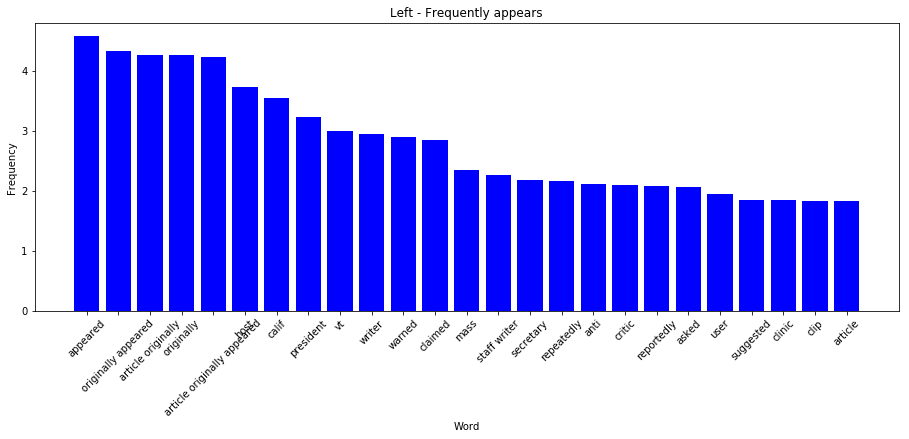

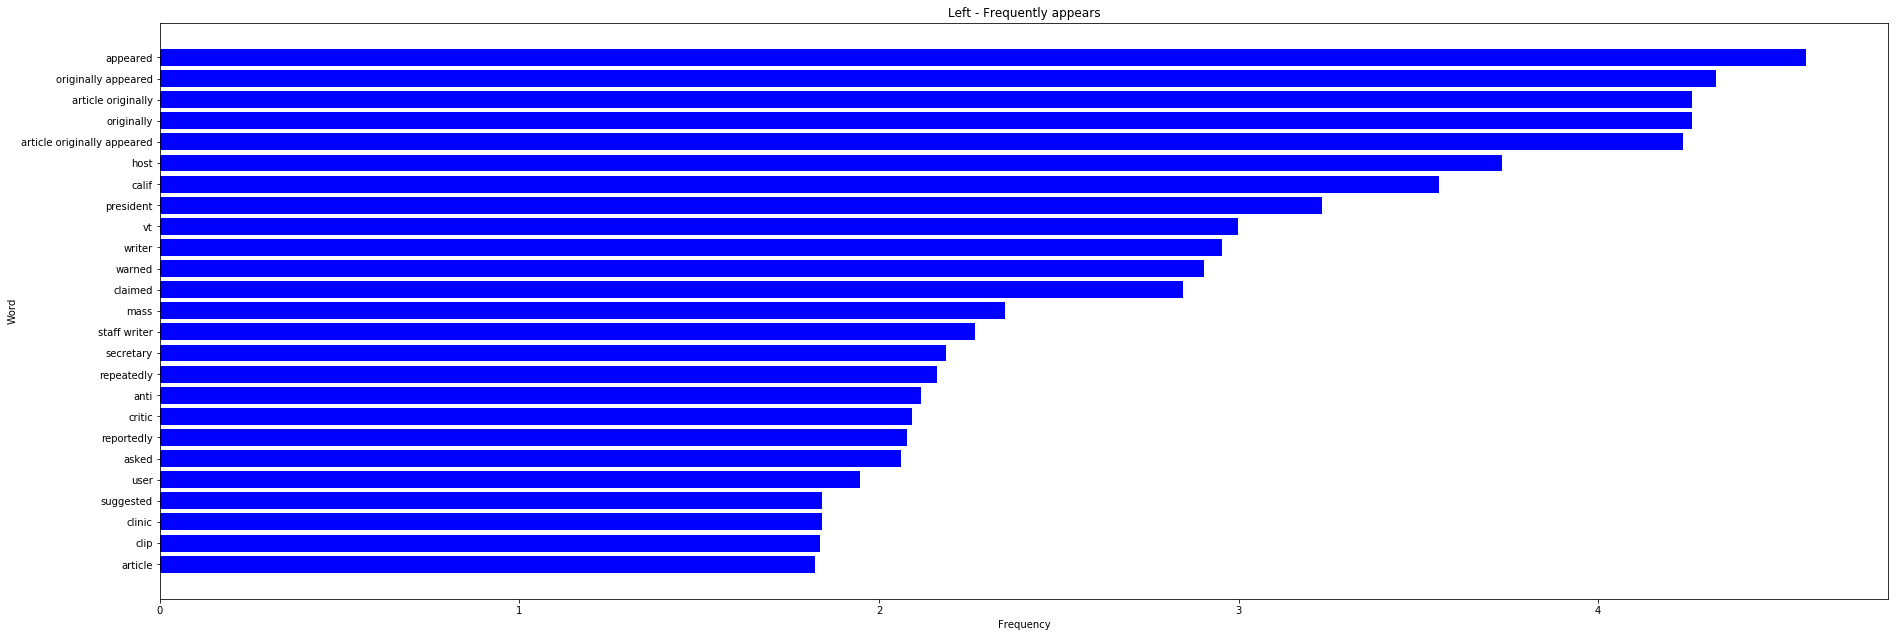

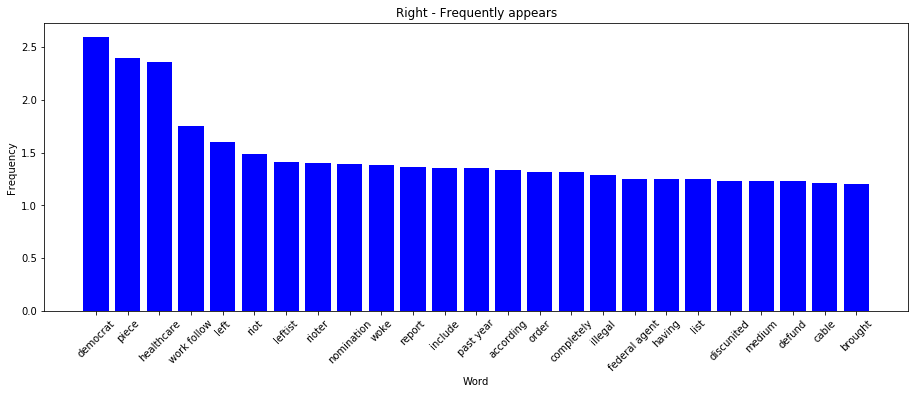

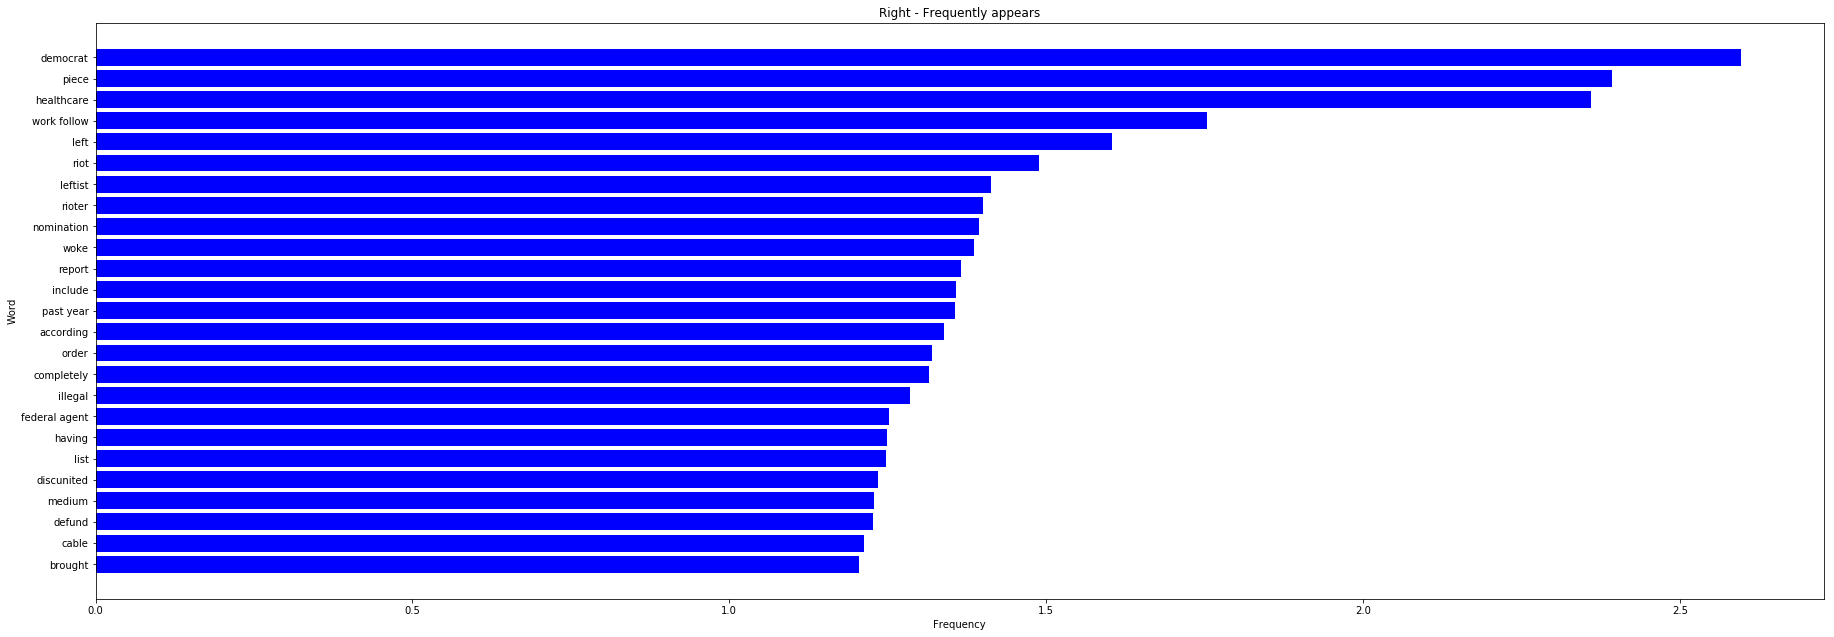

In [139]:
# Plot the most frequently occurring words seen in text labelled as right or left
# This works on the most recent clf, but should relatively represent the same features used by each classifier
# so long as the parameters for min_df and max_df for each classifier are the same
def plot_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names() # Get all the feature names that CountVectorizer() is using
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names)) # Put all feature names with their weights. Sort.
    
    # Left
    # Plot the results - vertical
    fig = plt.figure()
    ax = fig.add_axes([0,0,2,1])
    
    for word, totes in coefs_with_fns[:n]:    
        ax.bar(totes, word * -1, color='b')
        #plt.xticks(totes, word, rotation='vertical')

    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    plt.title('Left - Frequently appears')   
    plt.ylabel('Frequency')   
    plt.xlabel('Word')  
    plt.show()
    
    # Plot the results - horizontal
    fig = plt.figure()
    ax = fig.add_axes([0,0,4,2])
    
    for word, totes in coefs_with_fns[:n]:    
        ax.barh(totes, word * -1, color='b')
        #plt.xticks(totes, word, rotation='vertical')

    ax.invert_yaxis()
    plt.title('Left - Frequently appears')   
    plt.ylabel('Word')   
    plt.xlabel('Frequency')  
    plt.show()
    
    # Left
    # Plot the results - vertical
    fig = plt.figure()
    ax = fig.add_axes([0,0,2,1])
    
    for word, totes in coefs_with_fns[:-(n + 1):-1]:    
        ax.bar(totes, word, color='b')
        #plt.xticks(totes, word, rotation='vertical')

    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    plt.title('Right - Frequently appears')   
    plt.ylabel('Frequency')   
    plt.xlabel('Word')  
    plt.show()
    
    # Plot the results - horizontal
    fig = plt.figure()
    ax = fig.add_axes([0,0,4,2])
    
    for word, totes in coefs_with_fns[:-(n + 1):-1]:    
        ax.barh(totes, word, color='b')
        #plt.xticks(totes, word, rotation='vertical')

    ax.invert_yaxis()
    plt.title('Right - Frequently appears')   
    plt.ylabel('Word')   
    plt.xlabel('Frequency')  
    plt.show()
    
plot_most_informative_features(count_vect, clf, 25)

In [140]:
#print(count_vect.get_feature_names())

In [141]:
# Let's save our model
#joblib.dump(text_clf, 'pipeline.pkl')

Confusion Matrix:
[[3790  184]
 [ 356 3618]]
Accuracy Score : 0.9320583794665325
Report : 
              precision    recall  f1-score   support

       Right       0.91      0.95      0.93      3974
        Left       0.95      0.91      0.93      3974

    accuracy                           0.93      7948
   macro avg       0.93      0.93      0.93      7948
weighted avg       0.93      0.93      0.93      7948

             Confusion Matrix


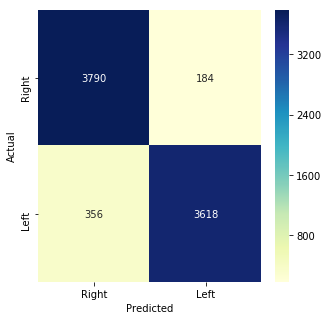

Classification Error of: 0.06794162053346754
95% Confidence Interval of: [0.0624091813258142, 0.07347405974112088]
Left = 0, Right = 1 

Predicted: 1 Actual: 0
This article originally appeared at Common Dreams. It is licensed under a Creative Commons Attribution-Share Alike 3.0 License. Feel free to republish and share widely.  A private warning about rising coronavirus cases made to leaders in 11 cities by White House official Dr. Deborah Birx on Wednesday is the latest sign that the Trump administration must end the secrecy surrounding its response to the pandemic, an investigative journalism group said Wednesday.  In an exclusive report about Birx's Wednesday phone call to city officials, the Center for Public Integrity (CPI) revealed that Baltimore, Cleveland, Columbus, Indianapolis, Las Vegas, Miami, Minneapolis, Nashville, New Orleans, Pittsburgh, and St. Louis have all been identified this week as cities where immediate, "aggressive" action is needed to mitigate their coronaviru

Highest performing classifier: Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.75, max_features=5000, min_df=4,
                                 ngram_range=(1, 2), stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('eclf',
                 VotingClassifier(estimators=[('svc',
                                               CalibratedClassifierCV(base_estimator=LinearSVC(random_state=0))),
                                              ('sgd',
                                               CalibratedClassifierCV(base_estimator=SGDClassifier(random_state=0))),
                                              ('rf',
                                               RandomForestClassifier(n_estimators=200,
                                                                      random_state=0))],
                                  voting='soft'))])


In [142]:
# End Results - Load the model and let's see the end results
text_clf = joblib.load('hs_and_nr_bigram_sr_l_pr.pkl')
predicted = text_clf.predict(all_data.unfiltered_articles)
#print(metrics.classification_report(test.pole, predicted, target_names=["NotSpam", "Spam"]))
tn, fp, fn, tp = metrics.confusion_matrix(all_data.pole, predicted).ravel()
results = metrics.confusion_matrix(all_data.pole, predicted)
#print((tn, fp, fn, tp))
print("Confusion Matrix:")
print(results)
print('Accuracy Score :', metrics.accuracy_score(all_data.pole, predicted))
print('Report : ')
print(metrics.classification_report(all_data.pole, predicted, target_names=["Right", "Left"]))


print("             Confusion Matrix")
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(results, annot=True, fmt='d', cmap='YlGnBu',
           xticklabels=["Right","Left"], yticklabels=["Right","Left"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification Error
incorrect_predictions = fp + fn
total_predictions = tp + tn + fp + fn
classification_error = incorrect_predictions / total_predictions
print("Classification Error of:",classification_error)

# 95% Confidence Interval (const: 1.96)
# There is a 95% likelihood that the confidence interval [0.xx, 0.xx] 
# covers the true classification error of the model on unseen data.
confidence_interval = []
confidence_interval.append(classification_error - 1.96 * sqrt( (classification_error * (1 - classification_error)) / total_predictions))
confidence_interval.append(classification_error + 1.96 * sqrt( (classification_error * (1 - classification_error)) / total_predictions))
print("95% Confidence Interval of:",confidence_interval)

# Let's see some examples of how the model and original dataset is classifying text.
print("Left = 0, Right = 1 \n")
for x in range(5):
    print("Predicted:", predicted[x], end=" ")
    print("Actual:", all_data['pole'][x])
    print(all_data['unfiltered_articles'][x], end="\n\n")

print("Highest performing classifier:", text_clf)

In [143]:
# Write results to results.txt for the entire notebook's run.
acc = metrics.accuracy_score(all_data.pole, predicted)
acc = "Entire dataset accuracy: " + str(acc) + "\n"
f = open('results.txt', 'a+')
f.write(acc)
f.close()

In [151]:
for model, acc in final_model:
    print(acc)

0.7931027253668764
0.8356184486373165
0.8351781970649894
0.8481761006289309
0.6579874213836477
0.6655765199161423
0.8331865828092243
0.8528511530398324


In [152]:
for x in range(len(final_model)):
    print(final_model[x])

[Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.75, max_features=5000, min_df=4,
                                 ngram_range=(1, 3), stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', AdaBoostClassifier(random_state=0))]), 0.7931027253668764]
[Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.75, max_features=5000, min_df=4,
                                 ngram_range=(1, 3), stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(random_state=0))]), 0.8356184486373165]
[Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.75, max_features=5000, min_df=4,
                                 ngram_range=(1, 3), stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 CalibratedClassifierCV(base_estimator=LinearSVC(random_state=0)))]), 0.8351781970649894]
[Pipeline(steps=[('vect',
   

In [154]:
print(text_clf)

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.75, max_features=5000, min_df=4,
                                 ngram_range=(1, 3), stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('eclf',
                 VotingClassifier(estimators=[('svc',
                                               CalibratedClassifierCV(base_estimator=LinearSVC(random_state=0))),
                                              ('sgd',
                                               CalibratedClassifierCV(base_estimator=SGDClassifier(random_state=0))),
                                              ('rf',
                                               RandomForestClassifier(n_estimators=200,
                                                                      random_state=0))],
                                  voting='soft'))])
